<a href="https://colab.research.google.com/github/MEGmax/APS105/blob/main/Lab3_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://colab.research.google.com/drive/1TXqmP8HXxmeb0DiIacSYcA9Pbp-ALM7n?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import numpy as np


def loadData(target_classes):

    classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'] #Define the classes (letters A to I)

    # Define the data transforms for normalization and augmentation
    transformData = transforms.Compose([
    transforms.Resize((224, 224)), #ensure 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))]) #normalize RGB values


    root_path = '/content/drive/MyDrive/Lab3_Gestures_Summer' #path to dataset

    # Load training and validation data
    dataset = ImageFolder(root=root_path, transform=transformData)

    # Define the classes to exclude from training and validation
    classes_to_exclude = ['B', 'D'] #testing classes

    # Create a list of indices for training and validation data
    train_indices = []
    val_indices = []
    test_indices = []

    #loop through data in dataset and categorize as training, validation or testing data
    for idx, (image_path, label) in enumerate(dataset.imgs):
      className = classes[label]
      if className in classes_to_exclude and className in target_classes:
          test_indices.append(idx)  # Add to testing data
      elif className in target_classes:
          if random.random() < 0.8:
              train_indices.append(idx)  # Add to training data
          else:
              val_indices.append(idx)  # Add to validation data

    # Create Subset datasets using the indices
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    test_dataset = Subset(dataset, test_indices)

    return train_dataset, val_dataset, test_dataset, len(train_indices), len(val_indices), len(test_indices)


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

In [ ]:
import torch
import torch.nn as nn

# CNNs are commonly used for image classification tasks as they can effectively capture spatial patterns and hierarchical features in images.
# By training this CNN model on a dataset of ASL images, it can learn to recognize and classify different ASL gestures with good accuracy.
class CNN(nn.Module):
    def __init__(self, num_hidden_layers):
        super(CNN, self).__init__()

        # Convolutional layers

        # The first convolutional layer takes input of 3 channels (RGB images), produces 32 output channels, and uses a 3x3 kernel
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        # The second convolutional layer takes 32 input channels, produces 64 output channels, and uses a 3x3 kernel
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # The third convolutional layer takes 64 input channels, produces 128 output channels, and uses a 3x3 kernel
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        # The fourth convolutional layer takes 128 input channels, produces 256 output channels, and uses a 3x3 kernel
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        # The fifth convolutional layer takes 256 input channels, produces 512 output channels, and uses a 3x3 kernel
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        # Max pooling layer

        # The max pooling layer reduces the spatial dimensions of the input by taking the maximum value within each 2x2 window
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the size of the fully-connected layer input

        # Each pooling operation reduces the spatial dimensions by a factor of 2, so we have 7x7 spatial dimensions after the 5 pooling layers
        self.fc_input_size = 512 * 7 * 7

        # Fully-connected layers

        # The first fully-connected layer takes the flattened input and produces an output of size 512
        self.fc1 = nn.Linear(self.fc_input_size, 512)
        # The second fully-connected layer takes an input of size 512 and produces an output of size 256
        self.fc2 = nn.Linear(512, 256)
        # The third fully-connected layer takes an input of size 256 and produces an output of size 128
        self.fc3 = nn.Linear(256, 128)
        # The fourth fully-connected layer takes an input of size 128 and produces an output of size 9 (for 9 classes in ASL)
        self.fc4 = nn.Linear(128, 9)

        # Activation function

        # The ReLU activation function introduces non-linearity into the network
        self.relu = nn.ReLU()

        # Number of hidden layers
        self.num_hidden_layers = num_hidden_layers

    def forward(self, x):
        # Forward propagation through the network

        # Apply ReLU activation followed by the first convolutional layer
        x = self.relu(self.conv1(x))
        # Perform max pooling
        x = self.pool(x)

        # Apply ReLU activation followed by the second convolutional layer
        x = self.relu(self.conv2(x))
        # Perform max pooling
        x = self.pool(x)

        # Apply ReLU activation followed by the third convolutional layer
        x = self.relu(self.conv3(x))
        # Perform max pooling
        x = self.pool(x)

        # Apply ReLU activation followed by the fourth convolutional layer
        x = self.relu(self.conv4(x))
        # Perform max pooling
        x = self.pool(x)

        # Apply ReLU activation followed by the fifth convolutional layer
        x = self.relu(self.conv5(x))
        # Perform max pooling
        x = self.pool(x)

        # Flatten the input tensor
        x = x.view(x.size(0), -1)

        # Apply ReLU activation followed by the first fully-connected layer
        x = self.relu(self.fc1(x))
        # Apply ReLU activation followed by the second fully-connected layer
        x = self.relu(self.fc2(x))
        # Apply ReLU activation followed by the third fully-connected layer
        x = self.relu(self.fc3(x))
        # Apply the fourth fully-connected layer (no activation function is applied here)
        x = self.fc4(x)

        # Return the output
        return x


### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [ ]:
# The optimizer and loss function are chosen based on their suitability for the task of training a classification model.

# Optimizer: Adam
# Adam is a popular optimization algorithm that combines the advantages of both AdaGrad and RMSProp algorithms. It adapts the learning rate for each parameter individually, which helps in training the model efficiently. It is known for its fast convergence and good generalization performance. Here, the Adam optimizer is used with default parameters.

# Loss function: CrossEntropyLoss
# CrossEntropyLoss is commonly used for multi-class classification problems.
# It computes the cross-entropy loss between the predicted class probabilities and the true class labels.
# It is suitable for training a model that needs to classify images into multiple classes (in this case, ASL gestures).
# The CrossEntropyLoss function in PyTorch handles the softmax activation internally, making it convenient for this classification task.

# Choosing Adam optimizer and CrossEntropyLoss as the default options allows for efficient training and good performance in the ASL image classification task.

def train_model(model, train_loader, val_loader, criterion=nn.CrossEntropyLoss(), optimizer=optim.Adam, num_epochs=10):

    # This might be faster, use if possible
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Define lists
    train_losses = []
    val_losses = []
    train_errors = []
    val_errors = []

    # loop through the specified number of epochs
    for epoch in range(num_epochs):
        train_loss = 0.0
        val_loss = 0.0
        train_correct = 0
        val_correct = 0
        train_total = 0
        val_total = 0

        ######### Training ########
        model.train()
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model.forward(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracy = 100 * train_correct / train_total
        train_errors.append(100 - train_accuracy)

        ######### Validation ########
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model.forward(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracy = 100 * val_correct / val_total
        val_errors.append(100 - val_accuracy)

        # Print training progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Error: {train_errors[-1]:.2f}%, Val Loss: {val_loss:.4f}, Val Error: {val_errors[-1]:.2f}%")

    return train_losses, val_losses, train_errors, val_errors


**Loss Function Choice: CrossEntropyLoss**

The nn.CrossEntropyLoss() function is commonly used for multi-class classification tasks, making it suitable for ASL classification. It combines the softmax activation function and the negative log likelihood loss into a single efficient computation.

**Optimizer Choice: Adam**

By applying optim.Adam() on the model's parameters, this provides a mechanism to update the weights and biases of the CNN during training. The optimizer utilizes the computed gradients of the loss function to adjust the parameters, reducing the loss and improving the model's performance over time. For a CNN, which typically has many parameters to optimize, Adam's adaptive properties make it efficient and robust.

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

Epoch [1/100], Train Loss: 2.2022, Train Error: 84.00%, Val Loss: 2.1581, Val Error: 82.00%
Epoch [2/100], Train Loss: 2.1341, Train Error: 80.00%, Val Loss: 3.6505, Val Error: 88.00%
Epoch [3/100], Train Loss: 3.1273, Train Error: 77.00%, Val Loss: 2.1055, Val Error: 86.00%
Epoch [4/100], Train Loss: 2.0487, Train Error: 85.00%, Val Loss: 2.1375, Val Error: 86.00%
Epoch [5/100], Train Loss: 2.1285, Train Error: 85.00%, Val Loss: 2.1572, Val Error: 86.00%
Epoch [6/100], Train Loss: 2.1558, Train Error: 85.00%, Val Loss: 2.1633, Val Error: 86.00%
Epoch [7/100], Train Loss: 2.1636, Train Error: 85.00%, Val Loss: 2.1616, Val Error: 86.00%
Epoch [8/100], Train Loss: 2.1622, Train Error: 85.00%, Val Loss: 2.1546, Val Error: 86.00%
Epoch [9/100], Train Loss: 2.1546, Train Error: 85.00%, Val Loss: 2.1422, Val Error: 86.00%
Epoch [10/100], Train Loss: 2.1407, Train Error: 85.00%, Val Loss: 2.1234, Val Error: 86.00%
Epoch [11/100], Train Loss: 2.1188, Train Error: 85.00%, Val Loss: 2.0979, Val 

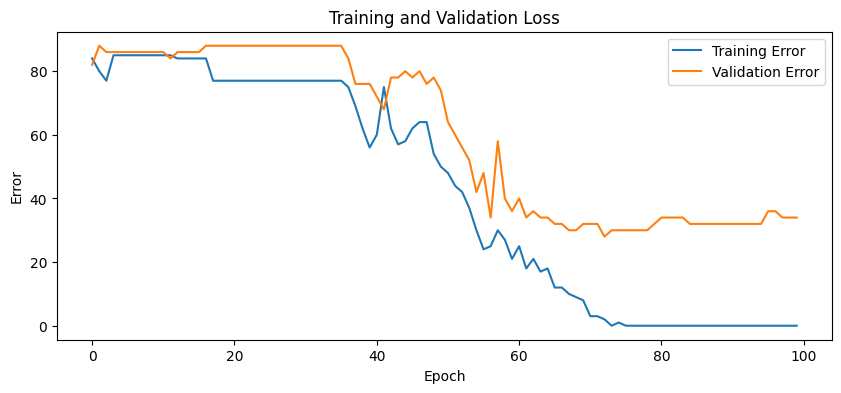

In [ ]:
import random
random.seed(42)

# Create a small subset of the training data for overfitting
train_dataset, val_dataset, _, _, _, _ = loadData(['A', 'C', 'E', 'F', 'G', 'H', 'I'])

# Randomly select 200 samples from the train and val datasets
train_indices = random.sample(range(len(train_dataset)), 100)
val_indices = random.sample(range(len(val_dataset)), 50)

# Create the subsets using the randomly selected indices
overfit_train_dataset = Subset(train_dataset, train_indices)
overfit_val_dataset = Subset(val_dataset, val_indices)


# Set the hyperparameters
num_channels = 3
num_hidden_layers = 75
learning_rate = 0.001
num_epochs = 100
batch_size = 100

# Initialize the model
model = CNN(num_hidden_layers)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Create data loaders for training and validation sets
overfit_train_loader = torch.utils.data.DataLoader(overfit_train_dataset, batch_size=batch_size, shuffle=True)
overfit_val_loader = torch.utils.data.DataLoader(overfit_val_dataset, batch_size=batch_size)

# Train the model with the overfit hyperparameters and overfit subset
train_losses, val_losses, train_errors, val_errors = train_model(model, overfit_train_loader, overfit_val_loader, criterion, optimizer, num_epochs)

plt.figure(figsize=(10, 4))
plt.plot(train_errors, label='Training Error')
plt.plot(val_errors, label='Validation Error')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()
plt.show()


### 3. Hyperparameter Search [10 pt]

### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

1. **Learning Rate:**

    The learning rate determines the step size at each iteration of the optimization algorithm (e.g., gradient descent). It affects how quickly or slowly the model learns. A learning rate that is too high can cause instability and prevent convergence, while a learning rate that is too low can result in slow training progress. Finding an optimal learning rate is crucial for achieving good model performance.
2. **Number of Hidden Units/Layers:**

  The architecture of a neural network, specifically the number of hidden units and layers, can greatly impact its representational capacity and learning capabilities. Increasing the number of hidden units or layers can provide the model with more capacity to learn complex patterns, but it may also lead to overfitting. Tuning the number of hidden units or layers can help strike the right balance between model complexity and generalization.
3. **Number of Epochs:**

  Tuning the number of epochs is crucial for finding the optimal balance between underfitting and overfitting. If the number of epochs is too low, the model may underfit and fail to capture the underlying patterns. Conversely, if the number of epochs is too high, the model may overfit by memorizing the training examples and performing poorly on new data. By monitoring the validation loss and implementing early stopping, tuning the number of epochs helps prevent overfitting while ensuring the model converges to an optimal solution, improving both performance and computational efficiency.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

In [ ]:
runCount = 6

Epoch [1/10], Train Loss: 2.2296, Train Error: 100.00%, Val Loss: 2.2218, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.2277, Train Error: 94.74%, Val Loss: 2.2199, Val Error: 73.83%
Epoch [3/10], Train Loss: 2.2258, Train Error: 81.93%, Val Loss: 2.2181, Val Error: 73.83%
Epoch [4/10], Train Loss: 2.2239, Train Error: 81.93%, Val Loss: 2.2162, Val Error: 73.83%
Epoch [5/10], Train Loss: 2.2220, Train Error: 81.93%, Val Loss: 2.2144, Val Error: 73.83%
Epoch [6/10], Train Loss: 2.2201, Train Error: 81.93%, Val Loss: 2.2126, Val Error: 73.83%
Epoch [7/10], Train Loss: 2.2182, Train Error: 81.93%, Val Loss: 2.2108, Val Error: 73.83%
Epoch [8/10], Train Loss: 2.2164, Train Error: 81.93%, Val Loss: 2.2090, Val Error: 73.83%
Epoch [9/10], Train Loss: 2.2145, Train Error: 81.93%, Val Loss: 2.2072, Val Error: 73.83%
Epoch [10/10], Train Loss: 2.2127, Train Error: 81.93%, Val Loss: 2.2054, Val Error: 73.83%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1529, Train Error: 81.93%, Val Loss: 2.1447, Val Error: 73.83%
Epoch [2/10], Train Loss: 2.1512, Train Error: 81.93%, Val Loss: 2.1430, Val Error: 73.83%
Epoch [3/10], Train Loss: 2.1495, Train Error: 81.93%, Val Loss: 2.1414, Val Error: 73.83%
Epoch [4/10], Train Loss: 2.1478, Train Error: 81.93%, Val Loss: 2.1398, Val Error: 73.83%
Epoch [5/10], Train Loss: 2.1462, Train Error: 81.93%, Val Loss: 2.1381, Val Error: 73.83%
Epoch [6/10], Train Loss: 2.1445, Train Error: 81.93%, Val Loss: 2.1365, Val Error: 73.83%
Epoch [7/10], Train Loss: 2.1429, Train Error: 81.93%, Val Loss: 2.1349, Val Error: 73.83%
Epoch [8/10], Train Loss: 2.1413, Train Error: 81.93%, Val Loss: 2.1333, Val Error: 73.83%
Epoch [9/10], Train Loss: 2.1396, Train Error: 81.93%, Val Loss: 2.1317, Val Error: 73.83%
Epoch [10/10], Train Loss: 2.1380, Train Error: 81.93%, Val Loss: 2.1301, Val Error: 73.83%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1866, Train Error: 100.00%, Val Loss: 2.1852, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.1847, Train Error: 100.00%, Val Loss: 2.1834, Val Error: 100.00%
Epoch [3/10], Train Loss: 2.1829, Train Error: 100.00%, Val Loss: 2.1816, Val Error: 100.00%
Epoch [4/10], Train Loss: 2.1811, Train Error: 100.00%, Val Loss: 2.1798, Val Error: 100.00%
Epoch [5/10], Train Loss: 2.1792, Train Error: 99.50%, Val Loss: 2.1780, Val Error: 88.67%
Epoch [6/10], Train Loss: 2.1774, Train Error: 80.14%, Val Loss: 2.1762, Val Error: 83.98%
Epoch [7/10], Train Loss: 2.1757, Train Error: 79.54%, Val Loss: 2.1745, Val Error: 83.98%
Epoch [8/10], Train Loss: 2.1739, Train Error: 79.54%, Val Loss: 2.1728, Val Error: 83.98%
Epoch [9/10], Train Loss: 2.1721, Train Error: 79.54%, Val Loss: 2.1711, Val Error: 83.98%
Epoch [10/10], Train Loss: 2.1704, Train Error: 79.54%, Val Loss: 2.1694, Val Error: 83.98%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1842, Train Error: 100.00%, Val Loss: 2.1857, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.1834, Train Error: 100.00%, Val Loss: 2.1848, Val Error: 100.00%
Epoch [3/10], Train Loss: 2.1825, Train Error: 100.00%, Val Loss: 2.1840, Val Error: 100.00%
Epoch [4/10], Train Loss: 2.1816, Train Error: 100.00%, Val Loss: 2.1831, Val Error: 100.00%
Epoch [5/10], Train Loss: 2.1807, Train Error: 100.00%, Val Loss: 2.1823, Val Error: 100.00%
Epoch [6/10], Train Loss: 2.1798, Train Error: 100.00%, Val Loss: 2.1814, Val Error: 100.00%
Epoch [7/10], Train Loss: 2.1789, Train Error: 100.00%, Val Loss: 2.1805, Val Error: 100.00%
Epoch [8/10], Train Loss: 2.1780, Train Error: 100.00%, Val Loss: 2.1797, Val Error: 100.00%
Epoch [9/10], Train Loss: 2.1772, Train Error: 100.00%, Val Loss: 2.1788, Val Error: 100.00%
Epoch [10/10], Train Loss: 2.1763, Train Error: 100.00%, Val Loss: 2.1780, Val Error: 100.00%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1901, Train Error: 78.55%, Val Loss: 2.1895, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1892, Train Error: 78.55%, Val Loss: 2.1885, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.1882, Train Error: 78.55%, Val Loss: 2.1876, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.1873, Train Error: 78.55%, Val Loss: 2.1866, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.1863, Train Error: 78.55%, Val Loss: 2.1857, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.1854, Train Error: 78.55%, Val Loss: 2.1848, Val Error: 79.69%
Epoch [7/10], Train Loss: 2.1844, Train Error: 78.55%, Val Loss: 2.1838, Val Error: 79.69%
Epoch [8/10], Train Loss: 2.1835, Train Error: 78.55%, Val Loss: 2.1829, Val Error: 79.69%
Epoch [9/10], Train Loss: 2.1825, Train Error: 78.55%, Val Loss: 2.1820, Val Error: 79.69%
Epoch [10/10], Train Loss: 2.1816, Train Error: 78.55%, Val Loss: 2.1810, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1718, Train Error: 80.34%, Val Loss: 2.1702, Val Error: 81.64%
Epoch [2/10], Train Loss: 2.1710, Train Error: 80.34%, Val Loss: 2.1693, Val Error: 81.64%
Epoch [3/10], Train Loss: 2.1701, Train Error: 80.34%, Val Loss: 2.1685, Val Error: 81.64%
Epoch [4/10], Train Loss: 2.1693, Train Error: 80.34%, Val Loss: 2.1676, Val Error: 81.64%
Epoch [5/10], Train Loss: 2.1684, Train Error: 80.34%, Val Loss: 2.1668, Val Error: 81.64%
Epoch [6/10], Train Loss: 2.1676, Train Error: 80.34%, Val Loss: 2.1659, Val Error: 81.64%
Epoch [7/10], Train Loss: 2.1667, Train Error: 80.34%, Val Loss: 2.1651, Val Error: 81.64%
Epoch [8/10], Train Loss: 2.1658, Train Error: 80.34%, Val Loss: 2.1642, Val Error: 81.64%
Epoch [9/10], Train Loss: 2.1650, Train Error: 80.34%, Val Loss: 2.1634, Val Error: 81.64%
Epoch [10/10], Train Loss: 2.1641, Train Error: 80.34%, Val Loss: 2.1625, Val Error: 81.64%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1802, Train Error: 100.00%, Val Loss: 2.1861, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.1798, Train Error: 100.00%, Val Loss: 2.1857, Val Error: 100.00%
Epoch [3/10], Train Loss: 2.1793, Train Error: 100.00%, Val Loss: 2.1852, Val Error: 100.00%
Epoch [4/10], Train Loss: 2.1788, Train Error: 100.00%, Val Loss: 2.1848, Val Error: 100.00%
Epoch [5/10], Train Loss: 2.1784, Train Error: 100.00%, Val Loss: 2.1843, Val Error: 100.00%
Epoch [6/10], Train Loss: 2.1779, Train Error: 100.00%, Val Loss: 2.1839, Val Error: 100.00%
Epoch [7/10], Train Loss: 2.1774, Train Error: 100.00%, Val Loss: 2.1834, Val Error: 100.00%
Epoch [8/10], Train Loss: 2.1770, Train Error: 100.00%, Val Loss: 2.1830, Val Error: 100.00%
Epoch [9/10], Train Loss: 2.1765, Train Error: 100.00%, Val Loss: 2.1825, Val Error: 100.00%
Epoch [10/10], Train Loss: 2.1761, Train Error: 100.00%, Val Loss: 2.1821, Val Error: 100.00%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1918, Train Error: 79.64%, Val Loss: 2.1873, Val Error: 80.86%
Epoch [2/10], Train Loss: 2.1914, Train Error: 79.64%, Val Loss: 2.1869, Val Error: 80.86%
Epoch [3/10], Train Loss: 2.1909, Train Error: 79.64%, Val Loss: 2.1864, Val Error: 80.86%
Epoch [4/10], Train Loss: 2.1904, Train Error: 79.64%, Val Loss: 2.1860, Val Error: 80.86%
Epoch [5/10], Train Loss: 2.1899, Train Error: 79.64%, Val Loss: 2.1855, Val Error: 80.86%
Epoch [6/10], Train Loss: 2.1895, Train Error: 79.64%, Val Loss: 2.1851, Val Error: 80.86%
Epoch [7/10], Train Loss: 2.1890, Train Error: 79.64%, Val Loss: 2.1846, Val Error: 80.86%
Epoch [8/10], Train Loss: 2.1885, Train Error: 79.64%, Val Loss: 2.1842, Val Error: 80.86%
Epoch [9/10], Train Loss: 2.1881, Train Error: 79.64%, Val Loss: 2.1837, Val Error: 80.86%
Epoch [10/10], Train Loss: 2.1876, Train Error: 79.64%, Val Loss: 2.1832, Val Error: 80.86%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1833, Train Error: 81.93%, Val Loss: 2.1781, Val Error: 73.83%
Epoch [2/10], Train Loss: 2.1828, Train Error: 81.93%, Val Loss: 2.1777, Val Error: 73.83%
Epoch [3/10], Train Loss: 2.1824, Train Error: 81.93%, Val Loss: 2.1772, Val Error: 73.83%
Epoch [4/10], Train Loss: 2.1819, Train Error: 81.93%, Val Loss: 2.1768, Val Error: 73.83%
Epoch [5/10], Train Loss: 2.1815, Train Error: 81.93%, Val Loss: 2.1764, Val Error: 73.83%
Epoch [6/10], Train Loss: 2.1810, Train Error: 81.93%, Val Loss: 2.1759, Val Error: 73.83%
Epoch [7/10], Train Loss: 2.1806, Train Error: 81.93%, Val Loss: 2.1755, Val Error: 73.83%
Epoch [8/10], Train Loss: 2.1801, Train Error: 81.93%, Val Loss: 2.1750, Val Error: 73.83%
Epoch [9/10], Train Loss: 2.1797, Train Error: 81.93%, Val Loss: 2.1746, Val Error: 73.83%
Epoch [10/10], Train Loss: 2.1792, Train Error: 81.93%, Val Loss: 2.1742, Val Error: 73.83%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1940, Train Error: 100.00%, Val Loss: 2.1886, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.1920, Train Error: 100.00%, Val Loss: 2.1867, Val Error: 99.61%
Epoch [3/30], Train Loss: 2.1901, Train Error: 84.81%, Val Loss: 2.1849, Val Error: 73.83%
Epoch [4/30], Train Loss: 2.1882, Train Error: 81.93%, Val Loss: 2.1830, Val Error: 73.83%
Epoch [5/30], Train Loss: 2.1862, Train Error: 81.93%, Val Loss: 2.1812, Val Error: 73.83%
Epoch [6/30], Train Loss: 2.1843, Train Error: 81.93%, Val Loss: 2.1793, Val Error: 73.83%
Epoch [7/30], Train Loss: 2.1824, Train Error: 81.93%, Val Loss: 2.1775, Val Error: 73.83%
Epoch [8/30], Train Loss: 2.1805, Train Error: 81.93%, Val Loss: 2.1757, Val Error: 73.83%
Epoch [9/30], Train Loss: 2.1787, Train Error: 81.93%, Val Loss: 2.1739, Val Error: 73.83%
Epoch [10/30], Train Loss: 2.1768, Train Error: 81.93%, Val Loss: 2.1721, Val Error: 73.83%
Epoch [11/30], Train Loss: 2.1749, Train Error: 81.93%, Val Loss: 2.1703, Val Error: 7

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


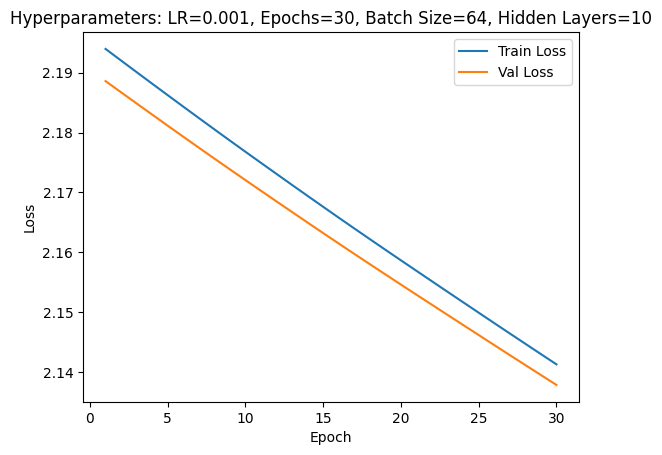

Epoch [1/30], Train Loss: 2.1977, Train Error: 81.93%, Val Loss: 2.1849, Val Error: 73.83%
Epoch [2/30], Train Loss: 2.1960, Train Error: 81.93%, Val Loss: 2.1832, Val Error: 73.83%
Epoch [3/30], Train Loss: 2.1943, Train Error: 81.93%, Val Loss: 2.1815, Val Error: 73.83%
Epoch [4/30], Train Loss: 2.1925, Train Error: 81.93%, Val Loss: 2.1799, Val Error: 73.83%
Epoch [5/30], Train Loss: 2.1908, Train Error: 81.93%, Val Loss: 2.1782, Val Error: 73.83%
Epoch [6/30], Train Loss: 2.1891, Train Error: 81.93%, Val Loss: 2.1766, Val Error: 73.83%
Epoch [7/30], Train Loss: 2.1874, Train Error: 81.93%, Val Loss: 2.1749, Val Error: 73.83%
Epoch [8/30], Train Loss: 2.1857, Train Error: 81.93%, Val Loss: 2.1733, Val Error: 73.83%
Epoch [9/30], Train Loss: 2.1840, Train Error: 81.93%, Val Loss: 2.1717, Val Error: 73.83%
Epoch [10/30], Train Loss: 2.1823, Train Error: 81.93%, Val Loss: 2.1701, Val Error: 73.83%
Epoch [11/30], Train Loss: 2.1807, Train Error: 81.93%, Val Loss: 2.1685, Val Error: 73.8

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.2363, Train Error: 100.00%, Val Loss: 2.2278, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.2342, Train Error: 100.00%, Val Loss: 2.2258, Val Error: 100.00%
Epoch [3/30], Train Loss: 2.2321, Train Error: 100.00%, Val Loss: 2.2237, Val Error: 100.00%
Epoch [4/30], Train Loss: 2.2300, Train Error: 100.00%, Val Loss: 2.2217, Val Error: 100.00%
Epoch [5/30], Train Loss: 2.2280, Train Error: 100.00%, Val Loss: 2.2197, Val Error: 100.00%
Epoch [6/30], Train Loss: 2.2259, Train Error: 100.00%, Val Loss: 2.2177, Val Error: 100.00%
Epoch [7/30], Train Loss: 2.2238, Train Error: 100.00%, Val Loss: 2.2157, Val Error: 100.00%
Epoch [8/30], Train Loss: 2.2217, Train Error: 100.00%, Val Loss: 2.2137, Val Error: 100.00%
Epoch [9/30], Train Loss: 2.2196, Train Error: 100.00%, Val Loss: 2.2117, Val Error: 100.00%
Epoch [10/30], Train Loss: 2.2176, Train Error: 100.00%, Val Loss: 2.2097, Val Error: 100.00%
Epoch [11/30], Train Loss: 2.2156, Train Error: 100.00%, Val Loss: 2.

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1948, Train Error: 100.00%, Val Loss: 2.1971, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.1939, Train Error: 100.00%, Val Loss: 2.1962, Val Error: 100.00%
Epoch [3/30], Train Loss: 2.1929, Train Error: 100.00%, Val Loss: 2.1953, Val Error: 100.00%
Epoch [4/30], Train Loss: 2.1920, Train Error: 100.00%, Val Loss: 2.1945, Val Error: 100.00%
Epoch [5/30], Train Loss: 2.1911, Train Error: 100.00%, Val Loss: 2.1936, Val Error: 100.00%
Epoch [6/30], Train Loss: 2.1902, Train Error: 100.00%, Val Loss: 2.1927, Val Error: 100.00%
Epoch [7/30], Train Loss: 2.1893, Train Error: 91.96%, Val Loss: 2.1918, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.1884, Train Error: 78.55%, Val Loss: 2.1909, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.1875, Train Error: 78.55%, Val Loss: 2.1901, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.1866, Train Error: 78.55%, Val Loss: 2.1892, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.1857, Train Error: 78.55%, Val Loss: 2.1883, Val

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1868, Train Error: 79.64%, Val Loss: 2.1893, Val Error: 80.86%
Epoch [2/30], Train Loss: 2.1859, Train Error: 79.64%, Val Loss: 2.1884, Val Error: 80.86%
Epoch [3/30], Train Loss: 2.1850, Train Error: 79.64%, Val Loss: 2.1876, Val Error: 80.86%
Epoch [4/30], Train Loss: 2.1841, Train Error: 79.64%, Val Loss: 2.1867, Val Error: 80.86%
Epoch [5/30], Train Loss: 2.1832, Train Error: 79.64%, Val Loss: 2.1858, Val Error: 80.86%
Epoch [6/30], Train Loss: 2.1823, Train Error: 79.64%, Val Loss: 2.1849, Val Error: 80.86%
Epoch [7/30], Train Loss: 2.1814, Train Error: 79.64%, Val Loss: 2.1841, Val Error: 80.86%
Epoch [8/30], Train Loss: 2.1805, Train Error: 79.64%, Val Loss: 2.1832, Val Error: 80.86%
Epoch [9/30], Train Loss: 2.1796, Train Error: 79.64%, Val Loss: 2.1823, Val Error: 80.86%
Epoch [10/30], Train Loss: 2.1787, Train Error: 79.64%, Val Loss: 2.1815, Val Error: 80.86%
Epoch [11/30], Train Loss: 2.1779, Train Error: 79.64%, Val Loss: 2.1806, Val Error: 80.8

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.2152, Train Error: 100.00%, Val Loss: 2.2153, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.2141, Train Error: 100.00%, Val Loss: 2.2142, Val Error: 100.00%
Epoch [3/30], Train Loss: 2.2130, Train Error: 100.00%, Val Loss: 2.2131, Val Error: 100.00%
Epoch [4/30], Train Loss: 2.2119, Train Error: 100.00%, Val Loss: 2.2121, Val Error: 100.00%
Epoch [5/30], Train Loss: 2.2108, Train Error: 100.00%, Val Loss: 2.2110, Val Error: 100.00%
Epoch [6/30], Train Loss: 2.2097, Train Error: 100.00%, Val Loss: 2.2099, Val Error: 100.00%
Epoch [7/30], Train Loss: 2.2086, Train Error: 90.07%, Val Loss: 2.2088, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.2075, Train Error: 78.55%, Val Loss: 2.2078, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.2065, Train Error: 78.55%, Val Loss: 2.2067, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.2054, Train Error: 78.55%, Val Loss: 2.2057, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.2043, Train Error: 78.55%, Val Loss: 2.2046, Val

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1955, Train Error: 100.00%, Val Loss: 2.2021, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.1950, Train Error: 100.00%, Val Loss: 2.2017, Val Error: 100.00%
Epoch [3/30], Train Loss: 2.1946, Train Error: 100.00%, Val Loss: 2.2013, Val Error: 100.00%
Epoch [4/30], Train Loss: 2.1941, Train Error: 100.00%, Val Loss: 2.2008, Val Error: 100.00%
Epoch [5/30], Train Loss: 2.1937, Train Error: 100.00%, Val Loss: 2.2004, Val Error: 100.00%
Epoch [6/30], Train Loss: 2.1932, Train Error: 100.00%, Val Loss: 2.1999, Val Error: 100.00%
Epoch [7/30], Train Loss: 2.1928, Train Error: 100.00%, Val Loss: 2.1995, Val Error: 100.00%
Epoch [8/30], Train Loss: 2.1923, Train Error: 100.00%, Val Loss: 2.1991, Val Error: 100.00%
Epoch [9/30], Train Loss: 2.1919, Train Error: 100.00%, Val Loss: 2.1986, Val Error: 100.00%
Epoch [10/30], Train Loss: 2.1915, Train Error: 100.00%, Val Loss: 2.1982, Val Error: 100.00%
Epoch [11/30], Train Loss: 2.1910, Train Error: 100.00%, Val Loss: 2.

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1910, Train Error: 80.34%, Val Loss: 2.1839, Val Error: 81.64%
Epoch [2/30], Train Loss: 2.1906, Train Error: 80.34%, Val Loss: 2.1834, Val Error: 81.64%
Epoch [3/30], Train Loss: 2.1901, Train Error: 80.34%, Val Loss: 2.1830, Val Error: 81.64%
Epoch [4/30], Train Loss: 2.1896, Train Error: 80.34%, Val Loss: 2.1826, Val Error: 81.64%
Epoch [5/30], Train Loss: 2.1892, Train Error: 80.34%, Val Loss: 2.1821, Val Error: 81.64%
Epoch [6/30], Train Loss: 2.1887, Train Error: 80.34%, Val Loss: 2.1817, Val Error: 81.64%
Epoch [7/30], Train Loss: 2.1883, Train Error: 80.34%, Val Loss: 2.1812, Val Error: 81.64%
Epoch [8/30], Train Loss: 2.1878, Train Error: 80.34%, Val Loss: 2.1808, Val Error: 81.64%
Epoch [9/30], Train Loss: 2.1873, Train Error: 80.34%, Val Loss: 2.1803, Val Error: 81.64%
Epoch [10/30], Train Loss: 2.1869, Train Error: 80.34%, Val Loss: 2.1799, Val Error: 81.64%
Epoch [11/30], Train Loss: 2.1864, Train Error: 80.34%, Val Loss: 2.1794, Val Error: 81.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1930, Train Error: 78.55%, Val Loss: 2.1942, Val Error: 79.69%
Epoch [2/30], Train Loss: 2.1925, Train Error: 78.55%, Val Loss: 2.1938, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.1919, Train Error: 78.55%, Val Loss: 2.1933, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.1914, Train Error: 78.55%, Val Loss: 2.1928, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.1909, Train Error: 78.55%, Val Loss: 2.1923, Val Error: 79.69%
Epoch [6/30], Train Loss: 2.1904, Train Error: 78.55%, Val Loss: 2.1918, Val Error: 79.69%
Epoch [7/30], Train Loss: 2.1899, Train Error: 78.55%, Val Loss: 2.1913, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.1894, Train Error: 78.55%, Val Loss: 2.1908, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.1889, Train Error: 78.55%, Val Loss: 2.1903, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.1884, Train Error: 78.55%, Val Loss: 2.1898, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.1879, Train Error: 78.55%, Val Loss: 2.1893, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1969, Train Error: 86.99%, Val Loss: 2.1807, Val Error: 80.86%
Epoch [2/10], Train Loss: 2.1780, Train Error: 79.64%, Val Loss: 2.1630, Val Error: 80.86%
Epoch [3/10], Train Loss: 2.1601, Train Error: 79.64%, Val Loss: 2.1463, Val Error: 80.86%
Epoch [4/10], Train Loss: 2.1431, Train Error: 79.74%, Val Loss: 2.1304, Val Error: 76.95%
Epoch [5/10], Train Loss: 2.1270, Train Error: 78.85%, Val Loss: 2.1152, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.1115, Train Error: 78.55%, Val Loss: 2.1006, Val Error: 79.69%
Epoch [7/10], Train Loss: 2.0965, Train Error: 78.55%, Val Loss: 2.0865, Val Error: 79.69%
Epoch [8/10], Train Loss: 2.0821, Train Error: 78.55%, Val Loss: 2.0729, Val Error: 79.69%
Epoch [9/10], Train Loss: 2.0681, Train Error: 78.55%, Val Loss: 2.0596, Val Error: 79.69%
Epoch [10/10], Train Loss: 2.0544, Train Error: 78.55%, Val Loss: 2.0467, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1922, Train Error: 83.22%, Val Loss: 2.1801, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1734, Train Error: 78.55%, Val Loss: 2.1622, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.1553, Train Error: 78.55%, Val Loss: 2.1452, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.1381, Train Error: 78.55%, Val Loss: 2.1291, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.1217, Train Error: 78.55%, Val Loss: 2.1136, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.1059, Train Error: 78.55%, Val Loss: 2.0987, Val Error: 79.69%
Epoch [7/10], Train Loss: 2.0909, Train Error: 78.55%, Val Loss: 2.0846, Val Error: 79.69%
Epoch [8/10], Train Loss: 2.0766, Train Error: 78.55%, Val Loss: 2.0710, Val Error: 79.69%
Epoch [9/10], Train Loss: 2.0629, Train Error: 78.55%, Val Loss: 2.0579, Val Error: 79.69%
Epoch [10/10], Train Loss: 2.0495, Train Error: 78.55%, Val Loss: 2.0452, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


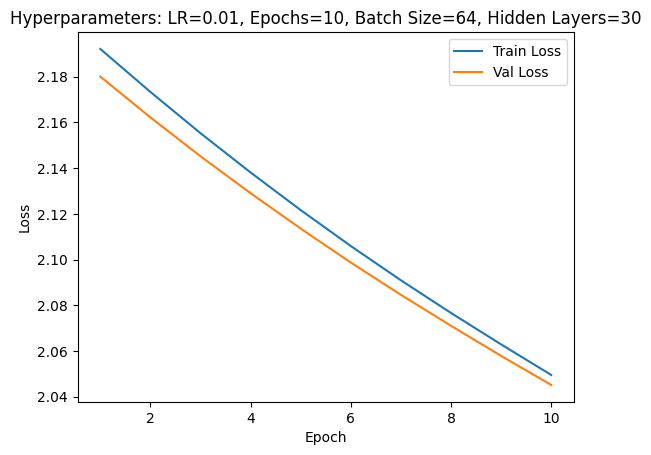

Epoch [1/10], Train Loss: 2.1803, Train Error: 80.34%, Val Loss: 2.1772, Val Error: 81.64%
Epoch [2/10], Train Loss: 2.1630, Train Error: 80.34%, Val Loss: 2.1605, Val Error: 81.64%
Epoch [3/10], Train Loss: 2.1465, Train Error: 80.34%, Val Loss: 2.1446, Val Error: 81.64%
Epoch [4/10], Train Loss: 2.1308, Train Error: 80.34%, Val Loss: 2.1293, Val Error: 81.64%
Epoch [5/10], Train Loss: 2.1157, Train Error: 80.34%, Val Loss: 2.1147, Val Error: 81.64%
Epoch [6/10], Train Loss: 2.1011, Train Error: 80.34%, Val Loss: 2.1005, Val Error: 81.64%
Epoch [7/10], Train Loss: 2.0870, Train Error: 80.34%, Val Loss: 2.0867, Val Error: 81.64%
Epoch [8/10], Train Loss: 2.0733, Train Error: 80.34%, Val Loss: 2.0732, Val Error: 81.64%
Epoch [9/10], Train Loss: 2.0597, Train Error: 80.34%, Val Loss: 2.0598, Val Error: 81.64%
Epoch [10/10], Train Loss: 2.0465, Train Error: 80.34%, Val Loss: 2.0469, Val Error: 81.64%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1697, Train Error: 80.34%, Val Loss: 2.1618, Val Error: 81.64%
Epoch [2/10], Train Loss: 2.1607, Train Error: 80.34%, Val Loss: 2.1532, Val Error: 81.64%
Epoch [3/10], Train Loss: 2.1519, Train Error: 80.34%, Val Loss: 2.1448, Val Error: 81.64%
Epoch [4/10], Train Loss: 2.1433, Train Error: 80.34%, Val Loss: 2.1366, Val Error: 81.64%
Epoch [5/10], Train Loss: 2.1349, Train Error: 80.34%, Val Loss: 2.1286, Val Error: 81.64%
Epoch [6/10], Train Loss: 2.1267, Train Error: 80.34%, Val Loss: 2.1208, Val Error: 81.64%
Epoch [7/10], Train Loss: 2.1186, Train Error: 80.34%, Val Loss: 2.1131, Val Error: 81.64%
Epoch [8/10], Train Loss: 2.1107, Train Error: 80.34%, Val Loss: 2.1055, Val Error: 81.64%
Epoch [9/10], Train Loss: 2.1028, Train Error: 80.34%, Val Loss: 2.0981, Val Error: 81.64%
Epoch [10/10], Train Loss: 2.0951, Train Error: 80.34%, Val Loss: 2.0907, Val Error: 81.64%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1953, Train Error: 100.00%, Val Loss: 2.1917, Val Error: 93.36%
Epoch [2/10], Train Loss: 2.1860, Train Error: 81.63%, Val Loss: 2.1826, Val Error: 80.86%
Epoch [3/10], Train Loss: 2.1769, Train Error: 79.64%, Val Loss: 2.1737, Val Error: 80.86%
Epoch [4/10], Train Loss: 2.1680, Train Error: 79.64%, Val Loss: 2.1651, Val Error: 80.86%
Epoch [5/10], Train Loss: 2.1594, Train Error: 79.64%, Val Loss: 2.1566, Val Error: 80.86%
Epoch [6/10], Train Loss: 2.1510, Train Error: 79.64%, Val Loss: 2.1483, Val Error: 80.86%
Epoch [7/10], Train Loss: 2.1426, Train Error: 79.64%, Val Loss: 2.1401, Val Error: 80.86%
Epoch [8/10], Train Loss: 2.1343, Train Error: 79.64%, Val Loss: 2.1319, Val Error: 80.86%
Epoch [9/10], Train Loss: 2.1262, Train Error: 79.64%, Val Loss: 2.1239, Val Error: 80.86%
Epoch [10/10], Train Loss: 2.1182, Train Error: 79.64%, Val Loss: 2.1161, Val Error: 80.86%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1852, Train Error: 95.63%, Val Loss: 2.1778, Val Error: 73.83%
Epoch [2/10], Train Loss: 2.1764, Train Error: 81.93%, Val Loss: 2.1693, Val Error: 73.83%
Epoch [3/10], Train Loss: 2.1678, Train Error: 81.93%, Val Loss: 2.1609, Val Error: 73.83%
Epoch [4/10], Train Loss: 2.1593, Train Error: 81.93%, Val Loss: 2.1527, Val Error: 73.83%
Epoch [5/10], Train Loss: 2.1511, Train Error: 81.93%, Val Loss: 2.1448, Val Error: 73.83%
Epoch [6/10], Train Loss: 2.1431, Train Error: 81.93%, Val Loss: 2.1371, Val Error: 73.83%
Epoch [7/10], Train Loss: 2.1352, Train Error: 81.93%, Val Loss: 2.1295, Val Error: 73.83%
Epoch [8/10], Train Loss: 2.1275, Train Error: 81.93%, Val Loss: 2.1220, Val Error: 73.83%
Epoch [9/10], Train Loss: 2.1198, Train Error: 81.93%, Val Loss: 2.1146, Val Error: 74.22%
Epoch [10/10], Train Loss: 2.1122, Train Error: 81.83%, Val Loss: 2.1073, Val Error: 83.98%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.2009, Train Error: 100.00%, Val Loss: 2.1953, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.1961, Train Error: 100.00%, Val Loss: 2.1907, Val Error: 100.00%
Epoch [3/10], Train Loss: 2.1914, Train Error: 94.44%, Val Loss: 2.1862, Val Error: 81.64%
Epoch [4/10], Train Loss: 2.1867, Train Error: 80.34%, Val Loss: 2.1817, Val Error: 81.64%
Epoch [5/10], Train Loss: 2.1821, Train Error: 80.34%, Val Loss: 2.1772, Val Error: 81.64%
Epoch [6/10], Train Loss: 2.1775, Train Error: 80.34%, Val Loss: 2.1728, Val Error: 81.64%
Epoch [7/10], Train Loss: 2.1729, Train Error: 80.34%, Val Loss: 2.1684, Val Error: 81.64%
Epoch [8/10], Train Loss: 2.1685, Train Error: 80.34%, Val Loss: 2.1641, Val Error: 81.64%
Epoch [9/10], Train Loss: 2.1640, Train Error: 80.34%, Val Loss: 2.1599, Val Error: 81.64%
Epoch [10/10], Train Loss: 2.1597, Train Error: 80.34%, Val Loss: 2.1557, Val Error: 81.64%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1866, Train Error: 78.55%, Val Loss: 2.1843, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1818, Train Error: 78.55%, Val Loss: 2.1797, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.1772, Train Error: 78.55%, Val Loss: 2.1752, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.1725, Train Error: 78.55%, Val Loss: 2.1708, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.1679, Train Error: 78.55%, Val Loss: 2.1663, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.1634, Train Error: 78.55%, Val Loss: 2.1620, Val Error: 79.69%
Epoch [7/10], Train Loss: 2.1590, Train Error: 78.55%, Val Loss: 2.1577, Val Error: 79.69%
Epoch [8/10], Train Loss: 2.1546, Train Error: 78.55%, Val Loss: 2.1534, Val Error: 79.69%
Epoch [9/10], Train Loss: 2.1502, Train Error: 78.55%, Val Loss: 2.1492, Val Error: 79.69%
Epoch [10/10], Train Loss: 2.1459, Train Error: 78.55%, Val Loss: 2.1451, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1903, Train Error: 100.00%, Val Loss: 2.1877, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.1855, Train Error: 100.00%, Val Loss: 2.1830, Val Error: 100.00%
Epoch [3/10], Train Loss: 2.1807, Train Error: 100.00%, Val Loss: 2.1785, Val Error: 100.00%
Epoch [4/10], Train Loss: 2.1760, Train Error: 100.00%, Val Loss: 2.1739, Val Error: 83.98%
Epoch [5/10], Train Loss: 2.1714, Train Error: 79.54%, Val Loss: 2.1694, Val Error: 83.98%
Epoch [6/10], Train Loss: 2.1668, Train Error: 79.54%, Val Loss: 2.1650, Val Error: 83.98%
Epoch [7/10], Train Loss: 2.1622, Train Error: 79.54%, Val Loss: 2.1606, Val Error: 83.98%
Epoch [8/10], Train Loss: 2.1578, Train Error: 79.54%, Val Loss: 2.1563, Val Error: 83.98%
Epoch [9/10], Train Loss: 2.1534, Train Error: 79.54%, Val Loss: 2.1521, Val Error: 83.98%
Epoch [10/10], Train Loss: 2.1491, Train Error: 79.54%, Val Loss: 2.1480, Val Error: 83.98%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.2137, Train Error: 100.00%, Val Loss: 2.2020, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.1933, Train Error: 92.45%, Val Loss: 2.1826, Val Error: 81.64%
Epoch [3/30], Train Loss: 2.1738, Train Error: 80.34%, Val Loss: 2.1641, Val Error: 81.64%
Epoch [4/30], Train Loss: 2.1551, Train Error: 80.34%, Val Loss: 2.1464, Val Error: 81.64%
Epoch [5/30], Train Loss: 2.1371, Train Error: 80.34%, Val Loss: 2.1293, Val Error: 81.64%
Epoch [6/30], Train Loss: 2.1199, Train Error: 80.34%, Val Loss: 2.1129, Val Error: 81.64%
Epoch [7/30], Train Loss: 2.1033, Train Error: 80.34%, Val Loss: 2.0972, Val Error: 81.64%
Epoch [8/30], Train Loss: 2.0874, Train Error: 80.34%, Val Loss: 2.0819, Val Error: 81.64%
Epoch [9/30], Train Loss: 2.0717, Train Error: 80.34%, Val Loss: 2.0670, Val Error: 81.64%
Epoch [10/30], Train Loss: 2.0564, Train Error: 79.54%, Val Loss: 2.0523, Val Error: 81.25%
Epoch [11/30], Train Loss: 2.0414, Train Error: 78.95%, Val Loss: 2.0379, Val Error: 79

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1604, Train Error: 81.93%, Val Loss: 2.1482, Val Error: 73.83%
Epoch [2/30], Train Loss: 2.1425, Train Error: 81.93%, Val Loss: 2.1312, Val Error: 73.83%
Epoch [3/30], Train Loss: 2.1255, Train Error: 80.83%, Val Loss: 2.1150, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.1093, Train Error: 78.75%, Val Loss: 2.0995, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.0937, Train Error: 78.35%, Val Loss: 2.0845, Val Error: 79.69%
Epoch [6/30], Train Loss: 2.0786, Train Error: 78.55%, Val Loss: 2.0700, Val Error: 81.25%
Epoch [7/30], Train Loss: 2.0639, Train Error: 78.85%, Val Loss: 2.0558, Val Error: 80.47%
Epoch [8/30], Train Loss: 2.0494, Train Error: 78.05%, Val Loss: 2.0417, Val Error: 77.73%
Epoch [9/30], Train Loss: 2.0349, Train Error: 77.46%, Val Loss: 2.0277, Val Error: 80.86%
Epoch [10/30], Train Loss: 2.0205, Train Error: 77.66%, Val Loss: 2.0135, Val Error: 82.81%
Epoch [11/30], Train Loss: 2.0057, Train Error: 78.95%, Val Loss: 1.9990, Val Error: 80.8

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1677, Train Error: 80.54%, Val Loss: 2.1633, Val Error: 81.64%
Epoch [2/30], Train Loss: 2.1503, Train Error: 80.14%, Val Loss: 2.1468, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.1340, Train Error: 78.55%, Val Loss: 2.1312, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.1184, Train Error: 78.55%, Val Loss: 2.1162, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.1034, Train Error: 78.55%, Val Loss: 2.1017, Val Error: 79.69%
Epoch [6/30], Train Loss: 2.0889, Train Error: 78.55%, Val Loss: 2.0880, Val Error: 79.69%
Epoch [7/30], Train Loss: 2.0754, Train Error: 78.55%, Val Loss: 2.0751, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.0623, Train Error: 78.55%, Val Loss: 2.0626, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.0498, Train Error: 78.55%, Val Loss: 2.0505, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.0375, Train Error: 78.55%, Val Loss: 2.0386, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.0254, Train Error: 78.55%, Val Loss: 2.0270, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


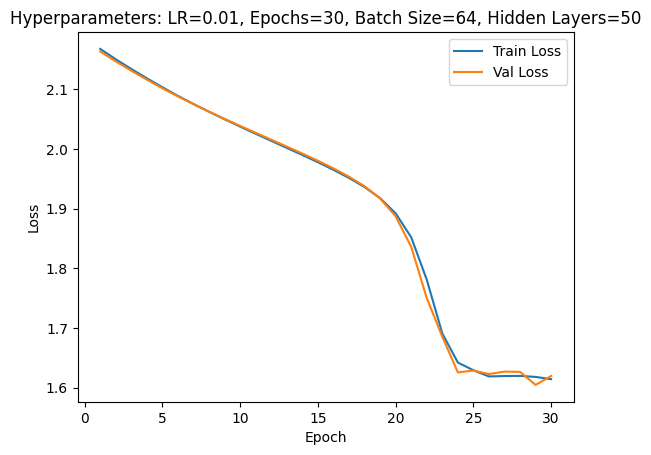

Epoch [1/30], Train Loss: 2.2003, Train Error: 81.93%, Val Loss: 2.1883, Val Error: 73.83%
Epoch [2/30], Train Loss: 2.1906, Train Error: 81.93%, Val Loss: 2.1790, Val Error: 73.83%
Epoch [3/30], Train Loss: 2.1811, Train Error: 81.93%, Val Loss: 2.1700, Val Error: 73.83%
Epoch [4/30], Train Loss: 2.1720, Train Error: 81.93%, Val Loss: 2.1613, Val Error: 73.83%
Epoch [5/30], Train Loss: 2.1631, Train Error: 81.93%, Val Loss: 2.1527, Val Error: 73.83%
Epoch [6/30], Train Loss: 2.1544, Train Error: 81.93%, Val Loss: 2.1445, Val Error: 73.83%
Epoch [7/30], Train Loss: 2.1461, Train Error: 81.93%, Val Loss: 2.1365, Val Error: 73.83%
Epoch [8/30], Train Loss: 2.1380, Train Error: 81.93%, Val Loss: 2.1288, Val Error: 73.83%
Epoch [9/30], Train Loss: 2.1301, Train Error: 81.93%, Val Loss: 2.1211, Val Error: 73.83%
Epoch [10/30], Train Loss: 2.1223, Train Error: 81.93%, Val Loss: 2.1136, Val Error: 73.83%
Epoch [11/30], Train Loss: 2.1146, Train Error: 81.93%, Val Loss: 2.1063, Val Error: 73.8

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.2158, Train Error: 82.82%, Val Loss: 2.2149, Val Error: 79.69%
Epoch [2/30], Train Loss: 2.2063, Train Error: 78.55%, Val Loss: 2.2058, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.1972, Train Error: 78.55%, Val Loss: 2.1970, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.1882, Train Error: 78.55%, Val Loss: 2.1883, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.1794, Train Error: 78.55%, Val Loss: 2.1799, Val Error: 79.69%
Epoch [6/30], Train Loss: 2.1708, Train Error: 78.55%, Val Loss: 2.1716, Val Error: 79.69%
Epoch [7/30], Train Loss: 2.1624, Train Error: 78.55%, Val Loss: 2.1635, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.1542, Train Error: 78.55%, Val Loss: 2.1555, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.1461, Train Error: 78.55%, Val Loss: 2.1478, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.1384, Train Error: 78.55%, Val Loss: 2.1404, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.1307, Train Error: 78.55%, Val Loss: 2.1330, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1979, Train Error: 87.79%, Val Loss: 2.1983, Val Error: 80.86%
Epoch [2/30], Train Loss: 2.1878, Train Error: 79.64%, Val Loss: 2.1886, Val Error: 80.86%
Epoch [3/30], Train Loss: 2.1779, Train Error: 79.64%, Val Loss: 2.1791, Val Error: 80.86%
Epoch [4/30], Train Loss: 2.1682, Train Error: 79.64%, Val Loss: 2.1698, Val Error: 80.86%
Epoch [5/30], Train Loss: 2.1587, Train Error: 79.64%, Val Loss: 2.1607, Val Error: 80.86%
Epoch [6/30], Train Loss: 2.1496, Train Error: 79.64%, Val Loss: 2.1519, Val Error: 80.86%
Epoch [7/30], Train Loss: 2.1406, Train Error: 79.64%, Val Loss: 2.1432, Val Error: 80.86%
Epoch [8/30], Train Loss: 2.1318, Train Error: 79.64%, Val Loss: 2.1347, Val Error: 80.86%
Epoch [9/30], Train Loss: 2.1233, Train Error: 79.64%, Val Loss: 2.1264, Val Error: 80.86%
Epoch [10/30], Train Loss: 2.1150, Train Error: 79.64%, Val Loss: 2.1185, Val Error: 80.86%
Epoch [11/30], Train Loss: 2.1069, Train Error: 79.64%, Val Loss: 2.1106, Val Error: 80.8

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1985, Train Error: 84.61%, Val Loss: 2.1930, Val Error: 79.69%
Epoch [2/30], Train Loss: 2.1935, Train Error: 78.55%, Val Loss: 2.1882, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.1885, Train Error: 78.55%, Val Loss: 2.1833, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.1836, Train Error: 78.55%, Val Loss: 2.1785, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.1787, Train Error: 78.55%, Val Loss: 2.1738, Val Error: 79.69%
Epoch [6/30], Train Loss: 2.1739, Train Error: 78.55%, Val Loss: 2.1691, Val Error: 79.69%
Epoch [7/30], Train Loss: 2.1692, Train Error: 78.55%, Val Loss: 2.1645, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.1645, Train Error: 78.55%, Val Loss: 2.1599, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.1599, Train Error: 78.55%, Val Loss: 2.1555, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.1554, Train Error: 78.55%, Val Loss: 2.1512, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.1510, Train Error: 78.55%, Val Loss: 2.1469, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1683, Train Error: 80.34%, Val Loss: 2.1672, Val Error: 81.64%
Epoch [2/30], Train Loss: 2.1639, Train Error: 80.34%, Val Loss: 2.1629, Val Error: 81.64%
Epoch [3/30], Train Loss: 2.1595, Train Error: 80.34%, Val Loss: 2.1587, Val Error: 81.64%
Epoch [4/30], Train Loss: 2.1552, Train Error: 80.34%, Val Loss: 2.1545, Val Error: 81.64%
Epoch [5/30], Train Loss: 2.1510, Train Error: 80.34%, Val Loss: 2.1504, Val Error: 81.64%
Epoch [6/30], Train Loss: 2.1468, Train Error: 80.34%, Val Loss: 2.1463, Val Error: 81.64%
Epoch [7/30], Train Loss: 2.1426, Train Error: 80.34%, Val Loss: 2.1423, Val Error: 81.64%
Epoch [8/30], Train Loss: 2.1385, Train Error: 79.94%, Val Loss: 2.1383, Val Error: 81.64%
Epoch [9/30], Train Loss: 2.1345, Train Error: 79.74%, Val Loss: 2.1345, Val Error: 80.08%
Epoch [10/30], Train Loss: 2.1305, Train Error: 78.95%, Val Loss: 2.1306, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.1266, Train Error: 78.55%, Val Loss: 2.1269, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1761, Train Error: 100.00%, Val Loss: 2.1714, Val Error: 100.00%
Epoch [2/30], Train Loss: 2.1716, Train Error: 91.36%, Val Loss: 2.1670, Val Error: 81.64%
Epoch [3/30], Train Loss: 2.1672, Train Error: 80.34%, Val Loss: 2.1627, Val Error: 81.64%
Epoch [4/30], Train Loss: 2.1628, Train Error: 80.34%, Val Loss: 2.1584, Val Error: 81.64%
Epoch [5/30], Train Loss: 2.1585, Train Error: 80.34%, Val Loss: 2.1542, Val Error: 81.64%
Epoch [6/30], Train Loss: 2.1542, Train Error: 80.34%, Val Loss: 2.1501, Val Error: 81.64%
Epoch [7/30], Train Loss: 2.1500, Train Error: 80.34%, Val Loss: 2.1460, Val Error: 81.64%
Epoch [8/30], Train Loss: 2.1459, Train Error: 80.34%, Val Loss: 2.1419, Val Error: 81.64%
Epoch [9/30], Train Loss: 2.1418, Train Error: 80.34%, Val Loss: 2.1379, Val Error: 81.64%
Epoch [10/30], Train Loss: 2.1377, Train Error: 80.34%, Val Loss: 2.1340, Val Error: 81.64%
Epoch [11/30], Train Loss: 2.1337, Train Error: 80.34%, Val Loss: 2.1301, Val Error: 81

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1552, Train Error: 79.64%, Val Loss: 2.1198, Val Error: 80.86%
Epoch [2/10], Train Loss: 2.0758, Train Error: 79.64%, Val Loss: 2.0483, Val Error: 80.86%
Epoch [3/10], Train Loss: 2.0053, Train Error: 79.64%, Val Loss: 1.9800, Val Error: 80.86%
Epoch [4/10], Train Loss: 1.9114, Train Error: 80.83%, Val Loss: 1.7868, Val Error: 83.98%
Epoch [5/10], Train Loss: 1.6671, Train Error: 78.15%, Val Loss: 1.6336, Val Error: 81.25%
Epoch [6/10], Train Loss: 1.6500, Train Error: 78.15%, Val Loss: 1.6435, Val Error: 79.69%
Epoch [7/10], Train Loss: 1.6341, Train Error: 81.03%, Val Loss: 1.6611, Val Error: 79.69%
Epoch [8/10], Train Loss: 1.6347, Train Error: 79.25%, Val Loss: 1.6164, Val Error: 74.61%
Epoch [9/10], Train Loss: 1.6086, Train Error: 74.68%, Val Loss: 1.6169, Val Error: 75.00%
Epoch [10/10], Train Loss: 1.6247, Train Error: 75.87%, Val Loss: 1.5700, Val Error: 65.23%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1576, Train Error: 79.94%, Val Loss: 2.1078, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.0811, Train Error: 78.55%, Val Loss: 2.0408, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.0152, Train Error: 78.55%, Val Loss: 1.9801, Val Error: 79.69%
Epoch [4/10], Train Loss: 1.9509, Train Error: 78.55%, Val Loss: 1.9118, Val Error: 79.69%
Epoch [5/10], Train Loss: 1.8192, Train Error: 79.34%, Val Loss: 1.6448, Val Error: 73.83%
Epoch [6/10], Train Loss: 1.6492, Train Error: 80.73%, Val Loss: 1.6850, Val Error: 79.69%
Epoch [7/10], Train Loss: 1.6536, Train Error: 80.24%, Val Loss: 1.6339, Val Error: 81.64%
Epoch [8/10], Train Loss: 1.6305, Train Error: 77.86%, Val Loss: 1.6242, Val Error: 80.86%
Epoch [9/10], Train Loss: 1.6194, Train Error: 77.46%, Val Loss: 1.6340, Val Error: 81.64%
Epoch [10/10], Train Loss: 1.6138, Train Error: 76.46%, Val Loss: 1.5809, Val Error: 72.66%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1625, Train Error: 82.22%, Val Loss: 2.1241, Val Error: 81.64%
Epoch [2/10], Train Loss: 2.0865, Train Error: 80.14%, Val Loss: 2.0560, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.0213, Train Error: 80.24%, Val Loss: 1.9953, Val Error: 79.69%
Epoch [4/10], Train Loss: 1.9609, Train Error: 79.94%, Val Loss: 1.9353, Val Error: 79.69%
Epoch [5/10], Train Loss: 1.8885, Train Error: 77.86%, Val Loss: 1.8153, Val Error: 79.69%
Epoch [6/10], Train Loss: 1.6936, Train Error: 81.03%, Val Loss: 1.6495, Val Error: 79.69%
Epoch [7/10], Train Loss: 1.6380, Train Error: 77.86%, Val Loss: 1.6410, Val Error: 83.98%
Epoch [8/10], Train Loss: 1.6400, Train Error: 78.45%, Val Loss: 1.6518, Val Error: 80.86%
Epoch [9/10], Train Loss: 1.6270, Train Error: 80.24%, Val Loss: 1.6810, Val Error: 74.61%
Epoch [10/10], Train Loss: 1.6240, Train Error: 77.46%, Val Loss: 1.6474, Val Error: 69.14%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1681, Train Error: 80.73%, Val Loss: 2.1429, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1286, Train Error: 78.55%, Val Loss: 2.1064, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.0928, Train Error: 78.55%, Val Loss: 2.0730, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.0597, Train Error: 78.55%, Val Loss: 2.0418, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.0281, Train Error: 78.55%, Val Loss: 2.0119, Val Error: 79.69%
Epoch [6/10], Train Loss: 1.9977, Train Error: 78.55%, Val Loss: 1.9822, Val Error: 79.69%
Epoch [7/10], Train Loss: 1.9664, Train Error: 78.55%, Val Loss: 1.9504, Val Error: 79.69%
Epoch [8/10], Train Loss: 1.9307, Train Error: 78.55%, Val Loss: 1.9076, Val Error: 79.69%
Epoch [9/10], Train Loss: 1.8641, Train Error: 78.55%, Val Loss: 1.7775, Val Error: 79.69%
Epoch [10/10], Train Loss: 1.6890, Train Error: 81.23%, Val Loss: 1.6566, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


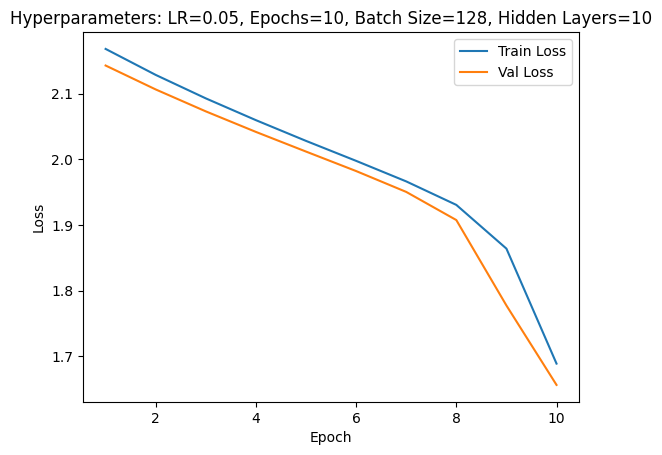

Epoch [1/10], Train Loss: 2.2056, Train Error: 89.47%, Val Loss: 2.1742, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1583, Train Error: 78.55%, Val Loss: 2.1316, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.1172, Train Error: 78.55%, Val Loss: 2.0933, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.0795, Train Error: 78.55%, Val Loss: 2.0575, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.0438, Train Error: 78.55%, Val Loss: 2.0228, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.0084, Train Error: 78.55%, Val Loss: 1.9867, Val Error: 79.69%
Epoch [7/10], Train Loss: 1.9688, Train Error: 78.55%, Val Loss: 1.9397, Val Error: 79.69%
Epoch [8/10], Train Loss: 1.9004, Train Error: 78.55%, Val Loss: 1.8046, Val Error: 79.69%
Epoch [9/10], Train Loss: 1.7023, Train Error: 77.76%, Val Loss: 1.6223, Val Error: 80.86%
Epoch [10/10], Train Loss: 1.6569, Train Error: 78.05%, Val Loss: 1.6250, Val Error: 80.47%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1722, Train Error: 88.78%, Val Loss: 2.1465, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1302, Train Error: 78.55%, Val Loss: 2.1084, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.0930, Train Error: 78.55%, Val Loss: 2.0748, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.0602, Train Error: 78.55%, Val Loss: 2.0449, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.0301, Train Error: 78.55%, Val Loss: 2.0169, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.0017, Train Error: 78.55%, Val Loss: 1.9907, Val Error: 79.69%
Epoch [7/10], Train Loss: 1.9752, Train Error: 78.55%, Val Loss: 1.9657, Val Error: 79.69%
Epoch [8/10], Train Loss: 1.9497, Train Error: 78.55%, Val Loss: 1.9418, Val Error: 79.69%
Epoch [9/10], Train Loss: 1.9251, Train Error: 78.55%, Val Loss: 1.9186, Val Error: 79.69%
Epoch [10/10], Train Loss: 1.9012, Train Error: 78.55%, Val Loss: 1.8957, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.2053, Train Error: 100.00%, Val Loss: 2.1864, Val Error: 100.00%
Epoch [2/10], Train Loss: 2.1814, Train Error: 85.60%, Val Loss: 2.1638, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.1586, Train Error: 78.55%, Val Loss: 2.1420, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.1366, Train Error: 78.55%, Val Loss: 2.1210, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.1152, Train Error: 78.55%, Val Loss: 2.1004, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.0943, Train Error: 78.55%, Val Loss: 2.0802, Val Error: 79.69%
Epoch [7/10], Train Loss: 2.0736, Train Error: 78.55%, Val Loss: 2.0600, Val Error: 79.69%
Epoch [8/10], Train Loss: 2.0526, Train Error: 78.55%, Val Loss: 2.0390, Val Error: 79.69%
Epoch [9/10], Train Loss: 2.0307, Train Error: 78.55%, Val Loss: 2.0163, Val Error: 79.69%
Epoch [10/10], Train Loss: 2.0061, Train Error: 78.55%, Val Loss: 1.9886, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1822, Train Error: 81.93%, Val Loss: 2.1581, Val Error: 73.83%
Epoch [2/10], Train Loss: 2.1606, Train Error: 81.93%, Val Loss: 2.1378, Val Error: 73.83%
Epoch [3/10], Train Loss: 2.1399, Train Error: 81.93%, Val Loss: 2.1186, Val Error: 73.83%
Epoch [4/10], Train Loss: 2.1203, Train Error: 81.93%, Val Loss: 2.1002, Val Error: 73.83%
Epoch [5/10], Train Loss: 2.1014, Train Error: 81.93%, Val Loss: 2.0823, Val Error: 73.83%
Epoch [6/10], Train Loss: 2.0831, Train Error: 81.93%, Val Loss: 2.0652, Val Error: 73.83%
Epoch [7/10], Train Loss: 2.0655, Train Error: 81.93%, Val Loss: 2.0486, Val Error: 73.83%
Epoch [8/10], Train Loss: 2.0485, Train Error: 81.93%, Val Loss: 2.0325, Val Error: 73.83%
Epoch [9/10], Train Loss: 2.0319, Train Error: 81.93%, Val Loss: 2.0167, Val Error: 73.83%
Epoch [10/10], Train Loss: 2.0156, Train Error: 81.93%, Val Loss: 2.0012, Val Error: 73.83%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/10], Train Loss: 2.1627, Train Error: 78.55%, Val Loss: 2.1461, Val Error: 79.69%
Epoch [2/10], Train Loss: 2.1404, Train Error: 78.55%, Val Loss: 2.1258, Val Error: 79.69%
Epoch [3/10], Train Loss: 2.1198, Train Error: 78.55%, Val Loss: 2.1065, Val Error: 79.69%
Epoch [4/10], Train Loss: 2.1002, Train Error: 78.55%, Val Loss: 2.0883, Val Error: 79.69%
Epoch [5/10], Train Loss: 2.0819, Train Error: 78.55%, Val Loss: 2.0711, Val Error: 79.69%
Epoch [6/10], Train Loss: 2.0644, Train Error: 78.55%, Val Loss: 2.0547, Val Error: 79.69%
Epoch [7/10], Train Loss: 2.0476, Train Error: 78.55%, Val Loss: 2.0388, Val Error: 79.69%
Epoch [8/10], Train Loss: 2.0313, Train Error: 78.55%, Val Loss: 2.0231, Val Error: 79.69%
Epoch [9/10], Train Loss: 2.0151, Train Error: 78.55%, Val Loss: 2.0076, Val Error: 79.69%
Epoch [10/10], Train Loss: 1.9990, Train Error: 78.55%, Val Loss: 1.9917, Val Error: 79.69%


<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1534, Train Error: 82.82%, Val Loss: 2.1045, Val Error: 81.64%
Epoch [2/30], Train Loss: 2.0781, Train Error: 80.34%, Val Loss: 2.0391, Val Error: 81.64%
Epoch [3/30], Train Loss: 2.0143, Train Error: 80.34%, Val Loss: 1.9820, Val Error: 81.64%
Epoch [4/30], Train Loss: 1.9560, Train Error: 80.34%, Val Loss: 1.9274, Val Error: 81.64%
Epoch [5/30], Train Loss: 1.8962, Train Error: 79.94%, Val Loss: 1.8624, Val Error: 79.69%
Epoch [6/30], Train Loss: 1.7744, Train Error: 78.55%, Val Loss: 1.6642, Val Error: 80.86%
Epoch [7/30], Train Loss: 1.6531, Train Error: 80.24%, Val Loss: 1.6150, Val Error: 73.83%
Epoch [8/30], Train Loss: 1.6322, Train Error: 80.34%, Val Loss: 1.6222, Val Error: 79.30%
Epoch [9/30], Train Loss: 1.6345, Train Error: 78.85%, Val Loss: 1.6245, Val Error: 79.69%
Epoch [10/30], Train Loss: 1.6212, Train Error: 78.15%, Val Loss: 1.6265, Val Error: 71.88%
Epoch [11/30], Train Loss: 1.6298, Train Error: 75.47%, Val Loss: 1.6753, Val Error: 81.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1540, Train Error: 79.54%, Val Loss: 2.1142, Val Error: 83.98%
Epoch [2/30], Train Loss: 2.0815, Train Error: 79.54%, Val Loss: 2.0501, Val Error: 83.98%
Epoch [3/30], Train Loss: 2.0194, Train Error: 79.54%, Val Loss: 1.9936, Val Error: 83.98%
Epoch [4/30], Train Loss: 1.9629, Train Error: 79.54%, Val Loss: 1.9407, Val Error: 83.98%
Epoch [5/30], Train Loss: 1.9079, Train Error: 79.54%, Val Loss: 1.8848, Val Error: 83.98%
Epoch [6/30], Train Loss: 1.8343, Train Error: 80.83%, Val Loss: 1.7637, Val Error: 82.03%
Epoch [7/30], Train Loss: 1.6695, Train Error: 80.54%, Val Loss: 1.6336, Val Error: 73.83%
Epoch [8/30], Train Loss: 1.6359, Train Error: 79.84%, Val Loss: 1.6639, Val Error: 79.69%
Epoch [9/30], Train Loss: 1.6297, Train Error: 79.34%, Val Loss: 1.6147, Val Error: 79.69%
Epoch [10/30], Train Loss: 1.6295, Train Error: 79.94%, Val Loss: 1.6539, Val Error: 79.69%
Epoch [11/30], Train Loss: 1.6309, Train Error: 81.43%, Val Loss: 1.6201, Val Error: 83.9

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1510, Train Error: 79.64%, Val Loss: 2.1062, Val Error: 80.86%
Epoch [2/30], Train Loss: 2.0757, Train Error: 79.64%, Val Loss: 2.0399, Val Error: 80.86%
Epoch [3/30], Train Loss: 2.0112, Train Error: 79.64%, Val Loss: 1.9784, Val Error: 80.86%
Epoch [4/30], Train Loss: 1.9441, Train Error: 79.64%, Val Loss: 1.8939, Val Error: 80.86%
Epoch [5/30], Train Loss: 1.7563, Train Error: 79.94%, Val Loss: 1.6324, Val Error: 73.44%
Epoch [6/30], Train Loss: 1.6505, Train Error: 78.95%, Val Loss: 1.6805, Val Error: 83.98%
Epoch [7/30], Train Loss: 1.6455, Train Error: 79.84%, Val Loss: 1.6391, Val Error: 81.64%
Epoch [8/30], Train Loss: 1.6274, Train Error: 76.96%, Val Loss: 1.6397, Val Error: 78.12%
Epoch [9/30], Train Loss: 1.6371, Train Error: 81.03%, Val Loss: 1.6030, Val Error: 73.83%
Epoch [10/30], Train Loss: 1.6351, Train Error: 77.66%, Val Loss: 1.6029, Val Error: 78.12%
Epoch [11/30], Train Loss: 1.6167, Train Error: 76.07%, Val Loss: 1.5940, Val Error: 81.2

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1607, Train Error: 83.71%, Val Loss: 2.1449, Val Error: 82.42%
Epoch [2/30], Train Loss: 2.1186, Train Error: 78.95%, Val Loss: 2.1061, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.0804, Train Error: 78.55%, Val Loss: 2.0702, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.0447, Train Error: 78.45%, Val Loss: 2.0357, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.0088, Train Error: 78.55%, Val Loss: 1.9977, Val Error: 79.69%
Epoch [6/30], Train Loss: 1.9635, Train Error: 78.05%, Val Loss: 1.9345, Val Error: 83.59%
Epoch [7/30], Train Loss: 1.8336, Train Error: 79.34%, Val Loss: 1.7032, Val Error: 80.86%
Epoch [8/30], Train Loss: 1.6693, Train Error: 82.03%, Val Loss: 1.6914, Val Error: 83.98%
Epoch [9/30], Train Loss: 1.6414, Train Error: 78.75%, Val Loss: 1.6363, Val Error: 79.69%
Epoch [10/30], Train Loss: 1.6464, Train Error: 80.64%, Val Loss: 1.6025, Val Error: 70.70%
Epoch [11/30], Train Loss: 1.6240, Train Error: 76.07%, Val Loss: 1.6511, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1826, Train Error: 88.88%, Val Loss: 2.1556, Val Error: 80.86%
Epoch [2/30], Train Loss: 2.1372, Train Error: 79.64%, Val Loss: 2.1147, Val Error: 80.86%
Epoch [3/30], Train Loss: 2.0973, Train Error: 79.64%, Val Loss: 2.0780, Val Error: 80.86%
Epoch [4/30], Train Loss: 2.0611, Train Error: 79.64%, Val Loss: 2.0437, Val Error: 80.86%
Epoch [5/30], Train Loss: 2.0265, Train Error: 79.64%, Val Loss: 2.0101, Val Error: 80.86%
Epoch [6/30], Train Loss: 1.9918, Train Error: 79.64%, Val Loss: 1.9746, Val Error: 80.86%
Epoch [7/30], Train Loss: 1.9519, Train Error: 79.84%, Val Loss: 1.9244, Val Error: 80.47%
Epoch [8/30], Train Loss: 1.8713, Train Error: 79.15%, Val Loss: 1.7643, Val Error: 82.42%
Epoch [9/30], Train Loss: 1.6779, Train Error: 80.24%, Val Loss: 1.6645, Val Error: 79.69%
Epoch [10/30], Train Loss: 1.6442, Train Error: 79.34%, Val Loss: 1.6249, Val Error: 80.86%
Epoch [11/30], Train Loss: 1.6387, Train Error: 80.34%, Val Loss: 1.6336, Val Error: 73.8

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


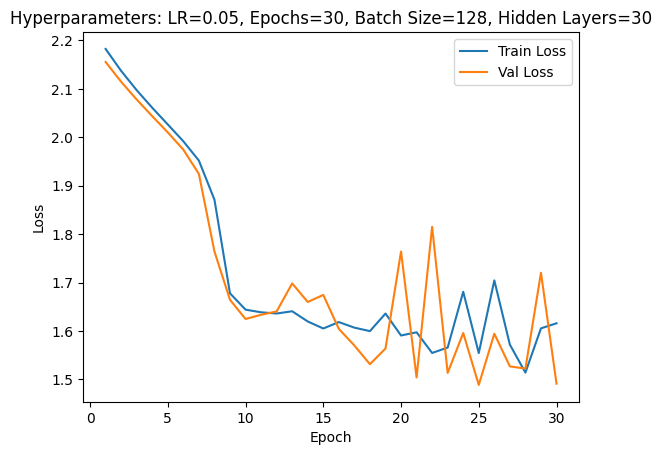

Epoch [1/30], Train Loss: 2.1884, Train Error: 81.03%, Val Loss: 2.1663, Val Error: 79.69%
Epoch [2/30], Train Loss: 2.1431, Train Error: 78.55%, Val Loss: 2.1256, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.1033, Train Error: 78.55%, Val Loss: 2.0891, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.0670, Train Error: 78.55%, Val Loss: 2.0547, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.0322, Train Error: 78.55%, Val Loss: 2.0213, Val Error: 79.69%
Epoch [6/30], Train Loss: 1.9970, Train Error: 78.55%, Val Loss: 1.9849, Val Error: 79.69%
Epoch [7/30], Train Loss: 1.9540, Train Error: 78.55%, Val Loss: 1.9300, Val Error: 79.69%
Epoch [8/30], Train Loss: 1.8542, Train Error: 80.04%, Val Loss: 1.7382, Val Error: 82.81%
Epoch [9/30], Train Loss: 1.6631, Train Error: 79.94%, Val Loss: 1.6632, Val Error: 77.34%
Epoch [10/30], Train Loss: 1.6473, Train Error: 79.25%, Val Loss: 1.6186, Val Error: 80.86%
Epoch [11/30], Train Loss: 1.6416, Train Error: 79.94%, Val Loss: 1.6211, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1776, Train Error: 78.55%, Val Loss: 2.1595, Val Error: 79.69%
Epoch [2/30], Train Loss: 2.1563, Train Error: 78.55%, Val Loss: 2.1398, Val Error: 79.69%
Epoch [3/30], Train Loss: 2.1366, Train Error: 78.55%, Val Loss: 2.1213, Val Error: 79.69%
Epoch [4/30], Train Loss: 2.1177, Train Error: 78.55%, Val Loss: 2.1035, Val Error: 79.69%
Epoch [5/30], Train Loss: 2.0997, Train Error: 78.55%, Val Loss: 2.0866, Val Error: 79.69%
Epoch [6/30], Train Loss: 2.0826, Train Error: 78.55%, Val Loss: 2.0705, Val Error: 79.69%
Epoch [7/30], Train Loss: 2.0662, Train Error: 78.55%, Val Loss: 2.0550, Val Error: 79.69%
Epoch [8/30], Train Loss: 2.0504, Train Error: 78.55%, Val Loss: 2.0401, Val Error: 79.69%
Epoch [9/30], Train Loss: 2.0350, Train Error: 78.55%, Val Loss: 2.0256, Val Error: 79.69%
Epoch [10/30], Train Loss: 2.0201, Train Error: 78.55%, Val Loss: 2.0115, Val Error: 79.69%
Epoch [11/30], Train Loss: 2.0057, Train Error: 78.55%, Val Loss: 1.9976, Val Error: 79.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1842, Train Error: 79.54%, Val Loss: 2.1740, Val Error: 83.98%
Epoch [2/30], Train Loss: 2.1618, Train Error: 79.54%, Val Loss: 2.1530, Val Error: 83.98%
Epoch [3/30], Train Loss: 2.1409, Train Error: 79.54%, Val Loss: 2.1332, Val Error: 83.98%
Epoch [4/30], Train Loss: 2.1211, Train Error: 79.54%, Val Loss: 2.1142, Val Error: 83.98%
Epoch [5/30], Train Loss: 2.1021, Train Error: 79.54%, Val Loss: 2.0960, Val Error: 83.98%
Epoch [6/30], Train Loss: 2.0839, Train Error: 79.54%, Val Loss: 2.0789, Val Error: 83.98%
Epoch [7/30], Train Loss: 2.0668, Train Error: 79.54%, Val Loss: 2.0624, Val Error: 83.98%
Epoch [8/30], Train Loss: 2.0502, Train Error: 79.54%, Val Loss: 2.0464, Val Error: 83.98%
Epoch [9/30], Train Loss: 2.0340, Train Error: 79.54%, Val Loss: 2.0307, Val Error: 83.98%
Epoch [10/30], Train Loss: 2.0181, Train Error: 79.54%, Val Loss: 2.0152, Val Error: 83.98%
Epoch [11/30], Train Loss: 2.0024, Train Error: 79.54%, Val Loss: 1.9998, Val Error: 83.9

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


Epoch [1/30], Train Loss: 2.1924, Train Error: 79.64%, Val Loss: 2.1763, Val Error: 80.86%
Epoch [2/30], Train Loss: 2.1692, Train Error: 79.64%, Val Loss: 2.1544, Val Error: 80.86%
Epoch [3/30], Train Loss: 2.1472, Train Error: 79.64%, Val Loss: 2.1335, Val Error: 80.86%
Epoch [4/30], Train Loss: 2.1262, Train Error: 79.64%, Val Loss: 2.1135, Val Error: 80.86%
Epoch [5/30], Train Loss: 2.1059, Train Error: 79.64%, Val Loss: 2.0940, Val Error: 80.86%
Epoch [6/30], Train Loss: 2.0859, Train Error: 79.64%, Val Loss: 2.0745, Val Error: 80.86%
Epoch [7/30], Train Loss: 2.0659, Train Error: 79.64%, Val Loss: 2.0546, Val Error: 79.30%
Epoch [8/30], Train Loss: 2.0450, Train Error: 80.34%, Val Loss: 2.0332, Val Error: 83.20%
Epoch [9/30], Train Loss: 2.0218, Train Error: 80.34%, Val Loss: 2.0078, Val Error: 81.64%
Epoch [10/30], Train Loss: 1.9919, Train Error: 80.34%, Val Loss: 1.9700, Val Error: 81.64%
Epoch [11/30], Train Loss: 1.9408, Train Error: 80.34%, Val Loss: 1.8873, Val Error: 81.6

<ipython-input-18-09b0b95ff038>:37: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results_df = results_df.append({


In [ ]:
runCount += 1
import pandas as pd

# Load the data
train_dataset, val_dataset, test_dataset, train_size, val_size, test_size = loadData(target_classes=['A', 'C', 'E', 'G', 'I'])

learning_rates = [0.001, 0.01, 0.05]
num_epochs_list = [10, 30]
batch_sizes = [64, 128, 256]
num_hidden_layers_list = [10, 30, 50]
models_trained = 0

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Create a DataFrame to store the results
results_df = pd.DataFrame(columns=["Learning Rate", "Num Epochs", "Batch Size", "Num Hidden Layers", "Train Losses", "Val Losses", 'Train Error', 'Val Error'])

for learning_rate in learning_rates:
    for num_epochs in num_epochs_list:
        for batch_size in batch_sizes:
            for num_hidden_layers in num_hidden_layers_list:
                # Create data loaders
                train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
                val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

                # Create an instance of the CNN model
                model = CNN(num_hidden_layers=num_hidden_layers)

                #Define the optimizer
                optimizer = optim.SGD(model.parameters(), lr=learning_rate)

                # Train and evaluate the model
                train_losses, val_losses, train_errors, val_errors = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)


                results_df = results_df.append({
                    "Learning Rate": learning_rate,
                    "Num Epochs": num_epochs,
                    "Batch Size": batch_size,
                    "Num Hidden Layers": num_hidden_layers,
                    "Train Losses": train_losses,
                    "Val Losses": val_losses,
                    'Train Error':train_errors,
                    'Val Error':val_errors
                }, ignore_index=True)

                models_trained += 1

                # Plot a graph after every 10 models
                if models_trained % 10 == 0:
                    plt.plot(range(1, num_epochs + 1), train_losses, label="Train Loss")
                    plt.plot(range(1, num_epochs + 1), val_losses, label="Val Loss")
                    plt.xlabel("Epoch")
                    plt.ylabel("Loss")
                    plt.title(f"Hyperparameters: LR={learning_rate}, Epochs={num_epochs}, Batch Size={batch_size}, Hidden Layers={num_hidden_layers}")
                    plt.legend()
                    plt.show()

# Save the results to a CSV file
results_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/hyperparameter_results_{runCount}.csv', index=False)


In [ ]:
# Read the CSV file
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/hyperparameter_results_7.csv')

# Display the contents of the CSV file
data

,Learning Rate,Num Epochs,Batch Size,Num Hidden Layers,Train Losses,Val Losses,Train Error,Val Error
0,0.001,10,64,10,"[2.2296277368672435, 2.227708932778094, 2.2257...","[2.2217745184898376, 2.2199186086654663, 2.218...","[100.0, 94.73684210526315, 81.92651439920556, ...","[100.0, 73.828125, 73.828125, 73.828125, 73.82..."
1,0.001,10,64,30,"[2.1528619102830326, 2.1511826022734355, 2.149...","[2.1446706652641296, 2.1430261731147766, 2.141...","[81.92651439920556, 81.92651439920556, 81.9265...","[73.828125, 73.828125, 73.828125, 73.828125, 7..."
2,0.001,10,64,50,"[2.186593671777871, 2.184743853050997, 2.18289...","[2.185173809528351, 2.183364152908325, 2.18156...","[100.0, 100.0, 100.0, 100.0, 99.50347567030785...","[100.0, 100.0, 100.0, 100.0, 88.671875, 83.984..."
3,0.001,10,128,10,"[2.1842453882260973, 2.1833516620950406, 2.182...","[2.185704827308655, 2.184840202331543, 2.18397...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
4,0.001,10,128,30,"[2.1901306959226092, 2.1891688341654048, 2.188...","[2.1894867420196533, 2.1885335445404053, 2.187...","[78.55014895729892, 78.55014895729892, 78.5501...","[79.6875, 79.6875, 79.6875, 79.6875, 79.6875, ..."
5,0.001,10,128,50,"[2.1718450515959207, 2.1709898893740824, 2.170...","[2.170156955718994, 2.169310212135315, 2.16846...","[80.33763654419067, 80.33763654419067, 80.3376...","[81.640625, 81.640625, 81.640625, 81.640625, 8..."
6,0.001,10,256,10,"[2.1802182654520013, 2.179754962040391, 2.1792...","[2.186128616333008, 2.185676336288452, 2.18522...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100...","[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100..."
7,0.001,10,256,30,"[2.191846288777629, 2.1913699088054, 2.1908952...","[2.187340497970581, 2.1868834495544434, 2.1864...","[79.64250248262165, 79.64250248262165, 79.6425...","[80.859375, 80.859375, 80.859375, 80.859375, 8..."
8,0.001,10,256,50,"[2.1832661742368544, 2.1828140130464466, 2.182...","[2.1780974864959717, 2.1776599884033203, 2.177...","[81.92651439920556, 81.92651439920556, 81.9265...","[73.828125, 73.828125, 73.828125, 73.828125, 7..."
9,0.001,30,64,10,"[2.193980179571703, 2.1920374107455545, 2.1900...","[2.1886035799980164, 2.186730921268463, 2.1848...","[100.0, 100.0, 84.80635551142007, 81.926514399...","[100.0, 99.609375, 73.828125, 73.828125, 73.82..."


### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

In [ ]:
#These were the paramters that resulted in the best training and validartion data and is what makes up the best model
learning_rate = 0.05
num_hidden_layers = 50
num_epochs = 30
batch_size = 256

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Create an instance of the CNN model
model = CNN(num_hidden_layers=num_hidden_layers)

#Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Train and evaluate the model
train_losses, val_losses, train_errors, val_errors = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

Epoch [1/30], Train Loss: 2.1952, Train Error: 85.00%, Val Loss: 2.1896, Val Error: 89.04%
Epoch [2/30], Train Loss: 2.1828, Train Error: 84.92%, Val Loss: 2.1782, Val Error: 89.04%
Epoch [3/30], Train Loss: 2.1714, Train Error: 84.92%, Val Loss: 2.1678, Val Error: 89.04%
Epoch [4/30], Train Loss: 2.1610, Train Error: 84.92%, Val Loss: 2.1582, Val Error: 89.04%
Epoch [5/30], Train Loss: 2.1514, Train Error: 84.92%, Val Loss: 2.1494, Val Error: 89.04%
Epoch [6/30], Train Loss: 2.1422, Train Error: 84.92%, Val Loss: 2.1409, Val Error: 89.04%
Epoch [7/30], Train Loss: 2.1337, Train Error: 84.92%, Val Loss: 2.1329, Val Error: 89.04%
Epoch [8/30], Train Loss: 2.1255, Train Error: 84.92%, Val Loss: 2.1252, Val Error: 89.04%
Epoch [9/30], Train Loss: 2.1177, Train Error: 84.92%, Val Loss: 2.1177, Val Error: 89.04%
Epoch [10/30], Train Loss: 2.1100, Train Error: 84.92%, Val Loss: 2.1104, Val Error: 89.04%
Epoch [11/30], Train Loss: 2.1023, Train Error: 84.92%, Val Loss: 2.1031, Val Error: 89.0

The best model that I trained had the hyperparameter settings:


*   Learning Rate = 0.05
*   Number of Hidden Layers = 50
*   Number of Epochs = 30
*   Batch Size = 256

This achieved a training loss of 0.000000 and a validation loss of 0.00000000, both of which were the lowest loss values out of all the models making it the best model that I have trained



### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
def calculate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in data_loader:

            outputs = model()
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = (correct / total) * 100
    return accuracy

# Calculate the test accuracy
train_dataset, val_dataset, test_dataset, _, _, _ = loadData(['B', 'D'])
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_accuracy = calculate_accuracy(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

calculate_accuracy()

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...

# Convert the data to PyTorch tensors
train_tensor = torch.Tensor(train_dataset)
val_tensor = torch.Tensor(val_dataset)
test_tensor = torch.Tensor(test_dataset)

# Compute the features for training data
train_features = alexnet.features(train_tensor)

# Compute the features for validation data
val_features = alexnet.features(val_tensor)

# Compute the features for test data
test_features = alexnet.features(test_tensor)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
# Save the computed features to files
torch.save(train_features, 'train_features.pth')
torch.save(val_features, 'val_features.pth')
torch.save(test_features, 'test_features.pth')

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

In [ ]:
# features = ... load precomputed alexnet.features(img) ...

import torch
import torch.nn as nn

class AlexNetModel(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetModel, self).__init__()

        # Define the layers of your model
        self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.relu2 = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(128 * 56 * 56, 256)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Define the forward pass of your model
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x


### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
tensor = torch.from_numpy(tensor.detach().numpy())

# Define the hyperparameters to tune
param_grid = {
    'hidden_size': [128, 256, 512],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Create new network instance
input_size = train_features_tensor.size(1)
num_classes = len(train_dataset.classes)
model = AlexNetModel(input_size, hidden_size=128, num_classes=num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the data to numpy arrays
train_labels = np.array(train_dataset.targets)
val_labels = np.array(val_dataset.targets)

# Perform grid search for hyperparameter tuning
grid_search = GridSearchCV(model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(train_features_np, train_labels)

# Get the best model and its hyperparameters
best_model = grid_search.best_estimator_
best_hidden_size = grid_search.best_params_['hidden_size']
best_learning_rate = grid_search.best_params_['learning_rate']

# Set the best hyperparameters to the model
best_model.fc1 = nn.Linear(input_size, best_hidden_size)
best_optimizer = optim.Adam(best_model.parameters(), lr=best_learning_rate)

# Train the best model
num_epochs = 10
train_loss_history = []
val_loss_history = []
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Training
    best_model.train()
    for features, labels in zip(train_features_tensor, train_labels):
        optimizer.zero_grad()
        outputs = best_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation
    best_model.eval()
    with torch.no_grad():
        for features, labels in zip(val_features_tensor, val_labels):
            outputs = best_model(features)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Compute average losses
    train_loss /= len(train_dataset)
    val_loss /= len(val_dataset)

    # Save loss history
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

    # Print epoch information
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Plot the training curve
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train')
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [ ]:
#It should be better